In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [18]:
#Data preparation: 

nov2014 = pd.read_csv("Nov2014.csv", sep= ';')                                 #Actual air reservations data. You can name the file however you want
nov2015 = pd.read_csv("Nov2015.csv", sep= ';') 
RBPD2014 = pd.read_csv("RelativeBookingsPerDay2014.csv", sep=';') 
RBPD2015 = pd.read_csv("RelativeBookingsPerDay2015.csv", sep=';') 

C:\Users\charl\Nueva carpeta\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In the same way that we can plot the relative % of cancellations each day for 2014 and 2015, we can add a condition before the calculation of those values, getting a subset of the data which meets a criteria (this 'condition' is the same as the LHS of the association rules), plotting it over the general view of cancellations each year can yield us a great way of understanding how passengers behave. Because its possible choose the conditions that want to be visualised each time, it could be developed as an application for the company

In [24]:
def compareEvents(compareVar, compareValue, year = 2015, wtp = 'FULL_CANCELLATION'):

    fix1 = nov2015
    fix2 = nov2014
    for i, var in enumerate(compareVar):
        fix1 = fix1[fix1[var] == compareValue[i]]
        
        fix2 = fix2[fix2[var] == compareValue[i]]

    general1 = RBPD2015
    general2 = RBPD2014
        
    books1 = fix1.loc[:, ['bookingdate', 'bookingsign']].groupby(by=['bookingdate', 'bookingsign']).size().unstack(fill_value = 0)
    books1.columns = books1.columns.astype(str)
    books1['TOTAL'] = books1.sum(axis=1)
    total_cancels = sum(books1['FULL_CANCELLATION'][13:])
    
    for book in books1.columns:
        books1[book] = books1[book] / books1['TOTAL']
        
    
    
    books2 = fix2.loc[:, ['bookingdate', 'bookingsign']].groupby(by=['bookingdate', 'bookingsign']).size().unstack(fill_value = 0)
    books2.columns = books2.columns.astype(str)
    books2['TOTAL'] = books2.sum(axis=1)
    for book in books2.columns:
        books2[book] = books2[book] / books2['TOTAL']
        
    plt.figure(figsize=(16,5), dpi=100)
    plt.plot(list(range(1, 29)), books1[wtp], color = 'red', label = f'2015 // {compareVar} == {compareValue}')
    plt.plot(list(range(1, 29)), books2[wtp], color = 'gold', label = f'2014 // {compareVar} == {compareValue}')
    
    plt.plot(list(range(1, 29)), general1[wtp], ':', color = 'red', label = f'2015')
    plt.plot(list(range(1, 29)), general2[wtp], ':', color = 'gold', label = f'2014')
    plt.title(f'{wtp}')
    plt.legend(prop={'size': 10})
    plt.show()
    print('Peak value: ', max(books1[wtp]))
    print(f'Total people with {wtp} from 13 to 31: ', total_cancels)
    print('Quantity of examples (2014, 2015): ', (len(fix2), len(fix1)))

Needs a list of columns variables, a list of values for those variables (together they are called conditions), and then its generalised for any kind of booking sign. In this case we care about the FULL CANCELLATIONS. 
It also calculates some values that could be of relative importance like the peak value of cancellations of 2015 WITH the condition. 

C:\Users\charl\Nueva carpeta\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\charl\Nueva carpeta\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


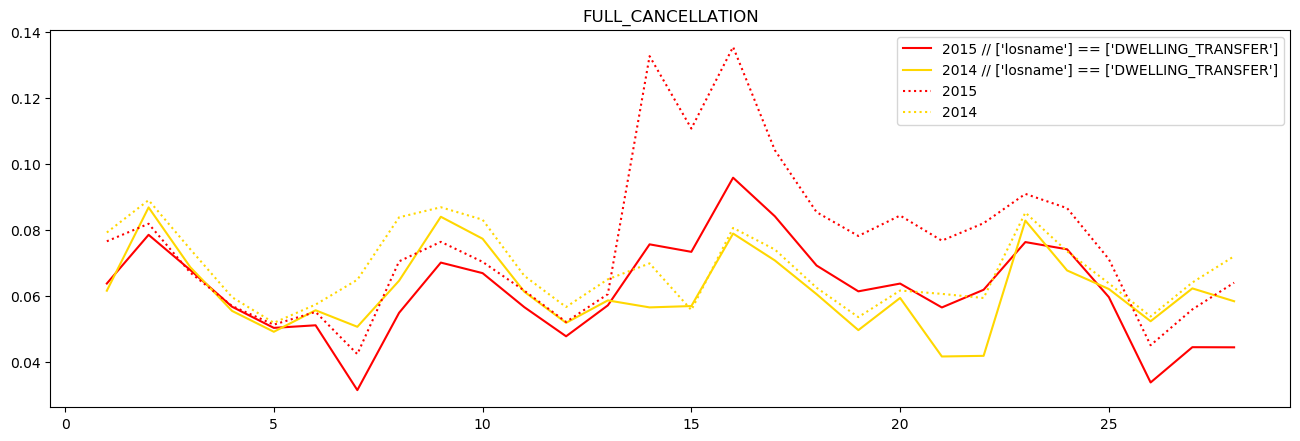

Peak value:  0.09573381743915584
Total people with FULL_CANCELLATION from 13 to 31:  28480
Quantity of examples (2014, 2015):  (814222, 867612)


In [21]:
compareEvents(['losname'], ['DWELLING_TRANSFER'], wtp = 'FULL_CANCELLATION')

Now we will use a greedy algorithm to calculate all possible permutations of combinations of the variables that we specify. For each combination we will calculate the peak value and the quantity of cancellations after the attack (from 13 to 31). This will give us even more information about which conditions are more important and influential than others. It could also be developed as a application for the company in the future, together with the function and plot before to visualise the conditions. 

In [22]:
import itertools
def findMax(compareVar, wtp = 'FULL_CANCELLATION'):
    totals = {}
    maxA = (0, '')
    fix1 = nov2015
    compareVals = list(list(fix1[n].unique()) for n in compareVar)
    combinations = [p for p in itertools.product(*compareVals)]

    for comb in combinations:
        fix1 = nov2015
        for i, val in enumerate(comb):
            fix1 = fix1[fix1[compareVar[i]] == val]

        if len(fix1) < 5000:
            continue

        books1 = fix1.loc[:, ['bookingdate', 'bookingsign']].groupby(by=['bookingdate', 'bookingsign']).size().unstack(fill_value = 0)
        books1.columns = books1.columns.astype(str)
        books1['TOTAL'] = books1.sum(axis=1)
        total_cancels = sum(books1['FULL_CANCELLATION'][13:])
        
        for book in books1.columns:
            books1[book] = books1[book] / books1['TOTAL']

        #print('Peak value: ', max(books1[wtp]))
        #print(f'Total people with {wtp}::{comb} : ', round(max(books1[wtp]) * len(fix1)))
        totals[comb] = (compareVar, max(books1[wtp]), total_cancels)
        
        if maxA[0] <  max(books1[wtp]):
            maxA = (max(books1[wtp]), comb, total_cancels)
            
    return totals

In [23]:
ele = ['paxprofile', 'losname', 'cabinclass','distchannel']
s = []
for i in range(len(ele)):
    C= itertools.combinations(ele, i+1)
    s += C
totals_total = {}
for comb in s:
    totals_total = {**totals_total, **findMax(list(comb))}

(0.20387131952017448, ('BUSINESS',), 52029)
(0.27205882352941174, ('TRANSIT',), 755)
(0.23127035830618892, ('F',), 1031)
(0.2811618725324309, ('CORPORATE',), 8736)
(0.3577531357934921, ('BUSINESS', 'STAY'), 15862)
(0.2906178489702517, ('BUSINESS', 'F'), 621)
(0.3007518796992481, ('BUSINESS', 'RETAIL'), 3119)
(0.38823529411764707, ('DAY_TRIP', 'B'), 518)
(0.4098550724637681, ('STAY', 'CORPORATE'), 4310)
(0.33665338645418325, ('B', 'CORPORATE'), 2830)
(0.41297756215888415, ('BUSINESS', 'STAY', 'B'), 5149)
(0.4376470588235294, ('BUSINESS', 'STAY', 'RETAIL'), 1329)
(0.3804347826086957, ('BUSINESS', 'B', 'RETAIL'), 1189)
(0.4807692307692308, ('STAY', 'B', 'CORPORATE'), 1406)
(0.4807692307692308, ('BUSINESS', 'STAY', 'B', 'CORPORATE'), 1403)


In [25]:
import heapq
maxs = heapq.nlargest(5, totals_total.items(), key=lambda i: i[1][1])
mins = heapq.nsmallest(5, totals_total.items(), key=lambda i: i[1][1])
maxs

[(('STAY', 'B', 'CORPORATE'),
  (['losname', 'cabinclass', 'distchannel'], 0.4807692307692308, 1406)),
 (('BUSINESS', 'STAY', 'B', 'CORPORATE'),
  (['paxprofile', 'losname', 'cabinclass', 'distchannel'],
   0.4807692307692308,
   1403)),
 (('BUSINESS', 'STAY', 'RETAIL'),
  (['paxprofile', 'losname', 'distchannel'], 0.4376470588235294, 1329)),
 (('BUSINESS', 'STAY', 'B'),
  (['paxprofile', 'losname', 'cabinclass'], 0.41297756215888415, 5149)),
 (('BUSINESS', 'STAY', 'CORPORATE'),
  (['paxprofile', 'losname', 'distchannel'], 0.41128563118091915, 4293))]